In [1]:
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras.utils.np_utils import to_categorical
from tqdm.keras import TqdmCallback

from src.data.ascad import AscadRandomKey
from src.dlla.hw import NUM_CLASSES, fetch_traces, plot_predictions, dlla_hw, p_gradient_dl_la, encode
from src.dlla.wegener import dlla_p_gradient_wegener, make_mlp_wegener
from src.tools.lists import random_divide
from src.tools.plotter import init_plots, plot_p_gradient, PALETTE_GRADIENT
from src.tvla.tvla import Tvla

init_plots()

TRACE_LENGTH = 1400

In [2]:
ascad = AscadRandomKey().default

x_prof, y_prof, x_att, y_att = fetch_traces(ascad)
y_att_unmasked = encode(ascad.attack.unmasked_labels())

### Model creation

With model hyperparameters to be optimized.

In [3]:
model_parameters = {
    'activation': ['relu'],
    'optimizer': [Adam(lr=0.001)],
    'losses': ['categorical_crossentropy'],
    'batch_size': list(np.linspace(100, 300, 5).astype(int)),
    'epochs': list(np.linspace(5, 20, 4).astype(int))
}

def make_mlp(x, y, x_attack, y_attack, params):
    mdl = Sequential()
    mdl.add(Dense(100, activation=params['activation'], input_shape=(1400,)))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(NUM_CLASSES, activation='softmax'))

    mdl.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=['accuracy'])

    out = mdl.fit(x, y, shuffle=True, validation_data=(x_attack, y_attack), batch_size=params['batch_size'],
                  epochs=params['epochs'], verbose=False, callbacks=[TqdmCallback(verbose=0)])

    return out, mdl

### Brute-force Hyper parameter optimization

Talos brute-force scan for optimal hyperparameters

In [4]:
# import talos
#
# scan_obj = talos.Scan(x=x_prof,    y=y_prof,    x_val=x_att,    y_val=y_att,    model=make_mlp,    params=model_parameters,    experiment_name=".cache/talos", print_params=True)

### Fit model based on the optimal model found by Talos.

In [5]:
best_model = make_mlp(x_prof, y_prof, x_att, y_att, {
    'activation':'relu',
    'optimizer': Adam(lr=0.001),
    'losses': 'categorical_crossentropy',
    'batch_size': 150,
    'epochs': 5
})[1]

### HW Prediction

Predict the hamming weight by taking the weighted mean for the predicted probabilities for each class.

#### Example: Some prediction

Probabilities for each class:

In [6]:
best_model.predict(x_att[:1])[0]

array([1.4956362e-04, 4.4690710e-03, 3.7278488e-02, 1.3543497e-01,
       3.0620760e-01, 2.6766324e-01, 1.8716396e-01, 5.5149406e-02,
       6.4837001e-03], dtype=float32)

**Predicted hamming weight label**, calculated by taking the weighted mean using the predicted probabilities.

In [7]:
np.sum(best_model.predict(x_att[:1])[0] * range(8 + 1))

4.609376777429134

In [8]:
dlla_hw(best_model, x_att, y_att)

(0.0, 0.7501633748876821)

### Plot prediction distribution for all traces.

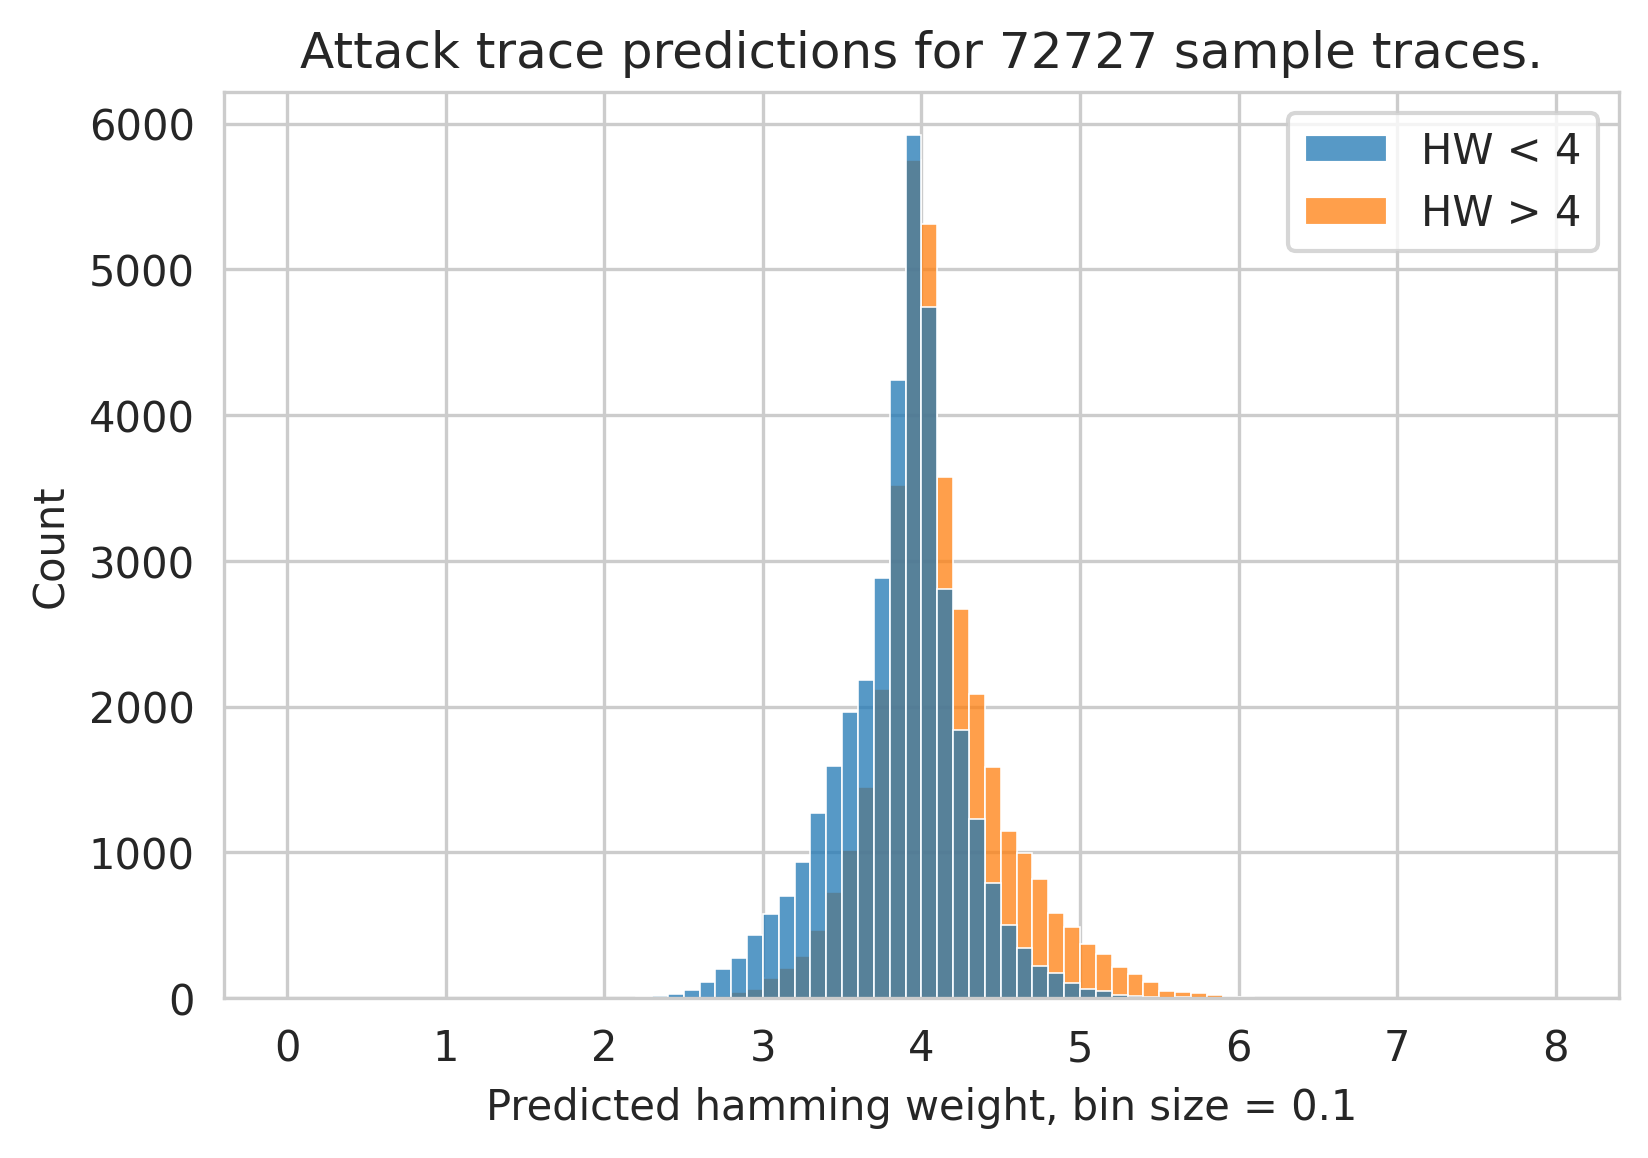

In [9]:
plot_predictions(best_model, x_att, y_att)

### Plot p-gradient.

In [10]:
def split_traces(x, y):
    yam = np.argmax(y, axis=1)
    a = x[np.where(yam < 4)]
    b = x[np.where(yam > 4)]

    min_len = min(len(a), len(b))
    return a[:min_len], b[:min_len]

A_ATT, B_ATT = split_traces(x_att, y_att_unmasked)

In [11]:
MAX_LEN = round(len(A_ATT) / 2)
TVLA_AB = Tvla(TRACE_LENGTH)
TVLA_AB.add(A_ATT[:MAX_LEN], B_ATT)

100%|██████████| 18153/18153 [00:45<00:00, 402.00it/s]


In [12]:
TVLA_BB = Tvla(TRACE_LENGTH)
TVLA_BB.add(*random_divide(B_ATT))

  0%|          | 0/17980 [00:00<?, ?it/s]/home/berg/Documents/Afstudeer/LA/src/tvla/tvla.py:50: RuntimeWarning: invalid value encountered in true_divide
  return self.cm[order] / (self.cm[2] ** (order / 2))
/home/berg/Documents/Afstudeer/LA/src/tvla/tvla.py:58: RuntimeWarning: invalid value encountered in true_divide
  return (self.cm[order * 2] - self.cm2[order]) / (self.cm[2] ** order)
100%|██████████| 17980/17980 [00:44<00:00, 403.85it/s]


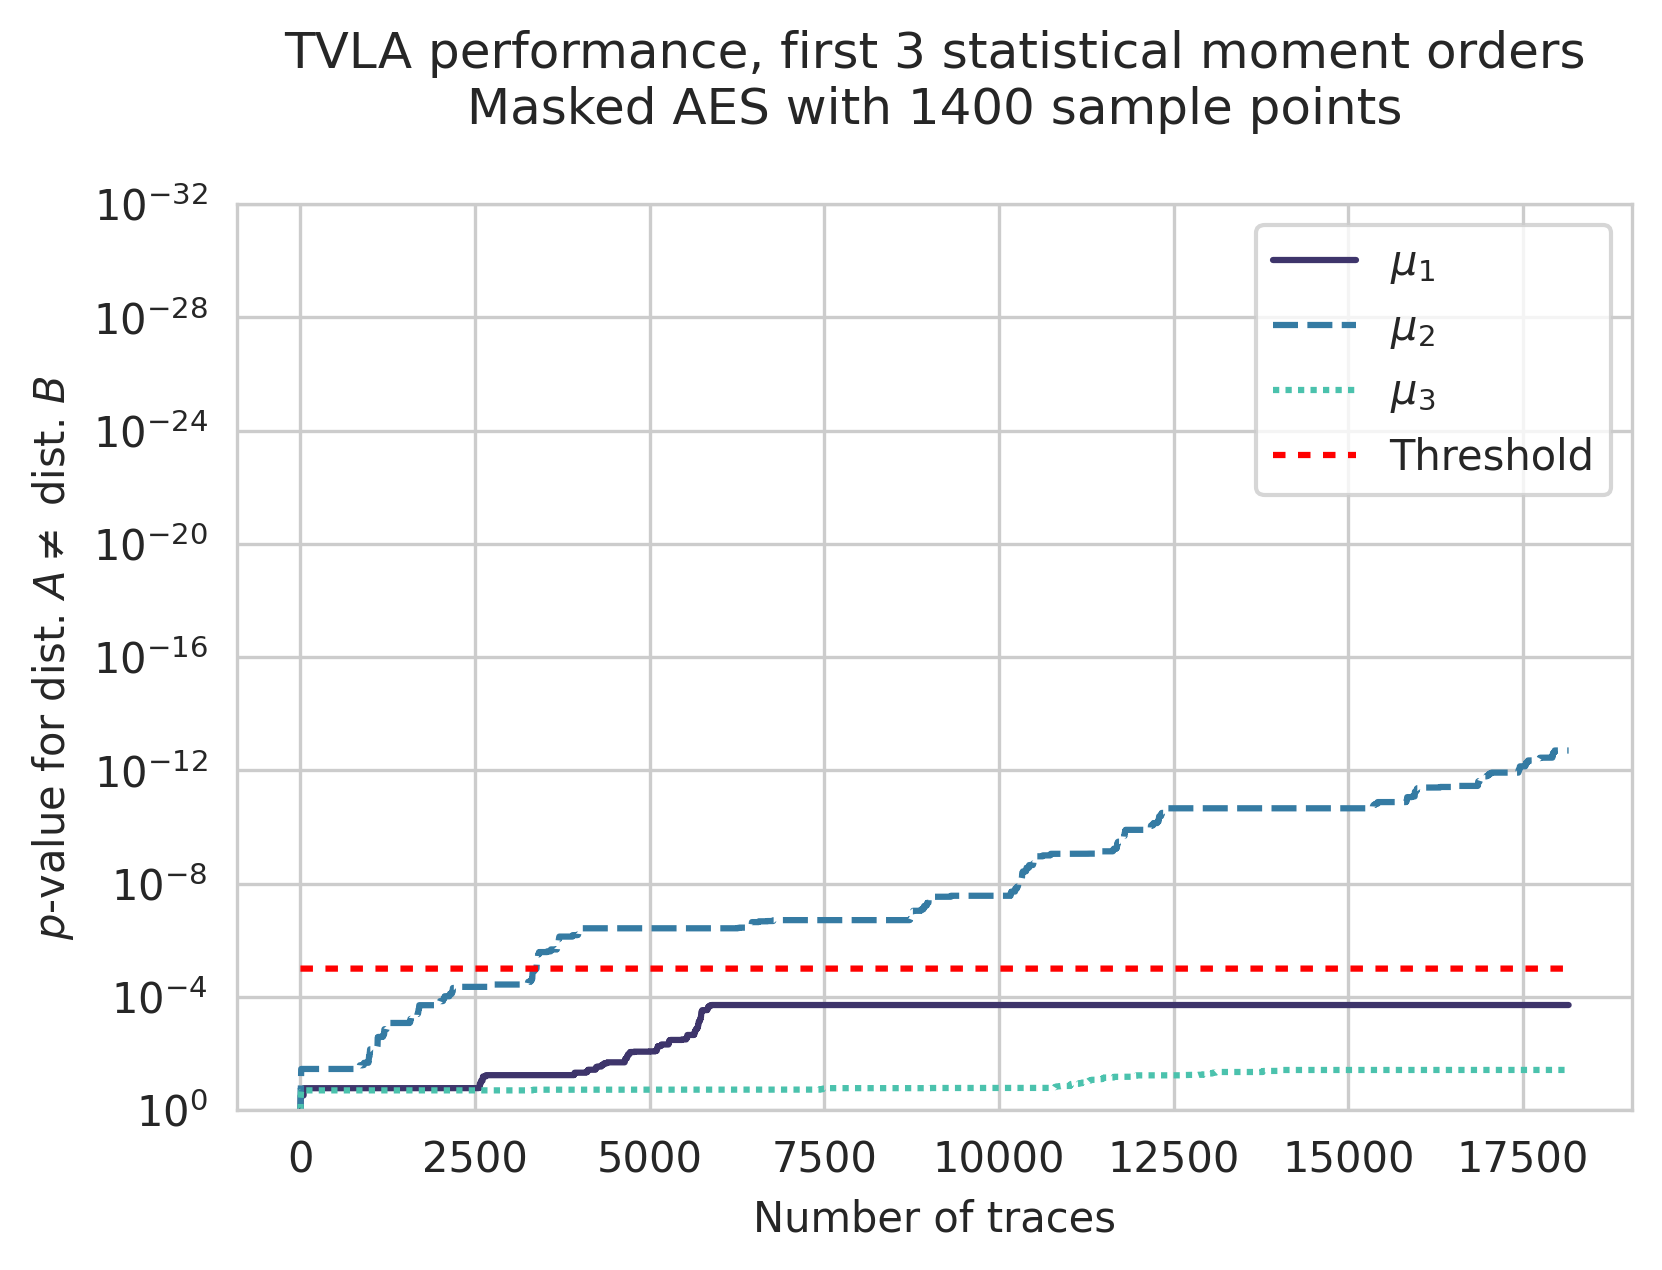

In [13]:
plot_p_gradient(dict([(f"$\\mu_{{{d}}}$", TVLA_AB.p_gradient(d)) for d in range(1, 4)]),
                "TVLA performance, first 3 statistical moment orders\nMasked AES with 1400 sample points\n", palette=PALETTE_GRADIENT)

/home/berg/Documents/Afstudeer/LA/src/tvla/tvla.py:137: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  g.set(yscale="log", ylabel="$p$-value for dist. $A \\neq$ dist. $B$", xlabel="Sample point",


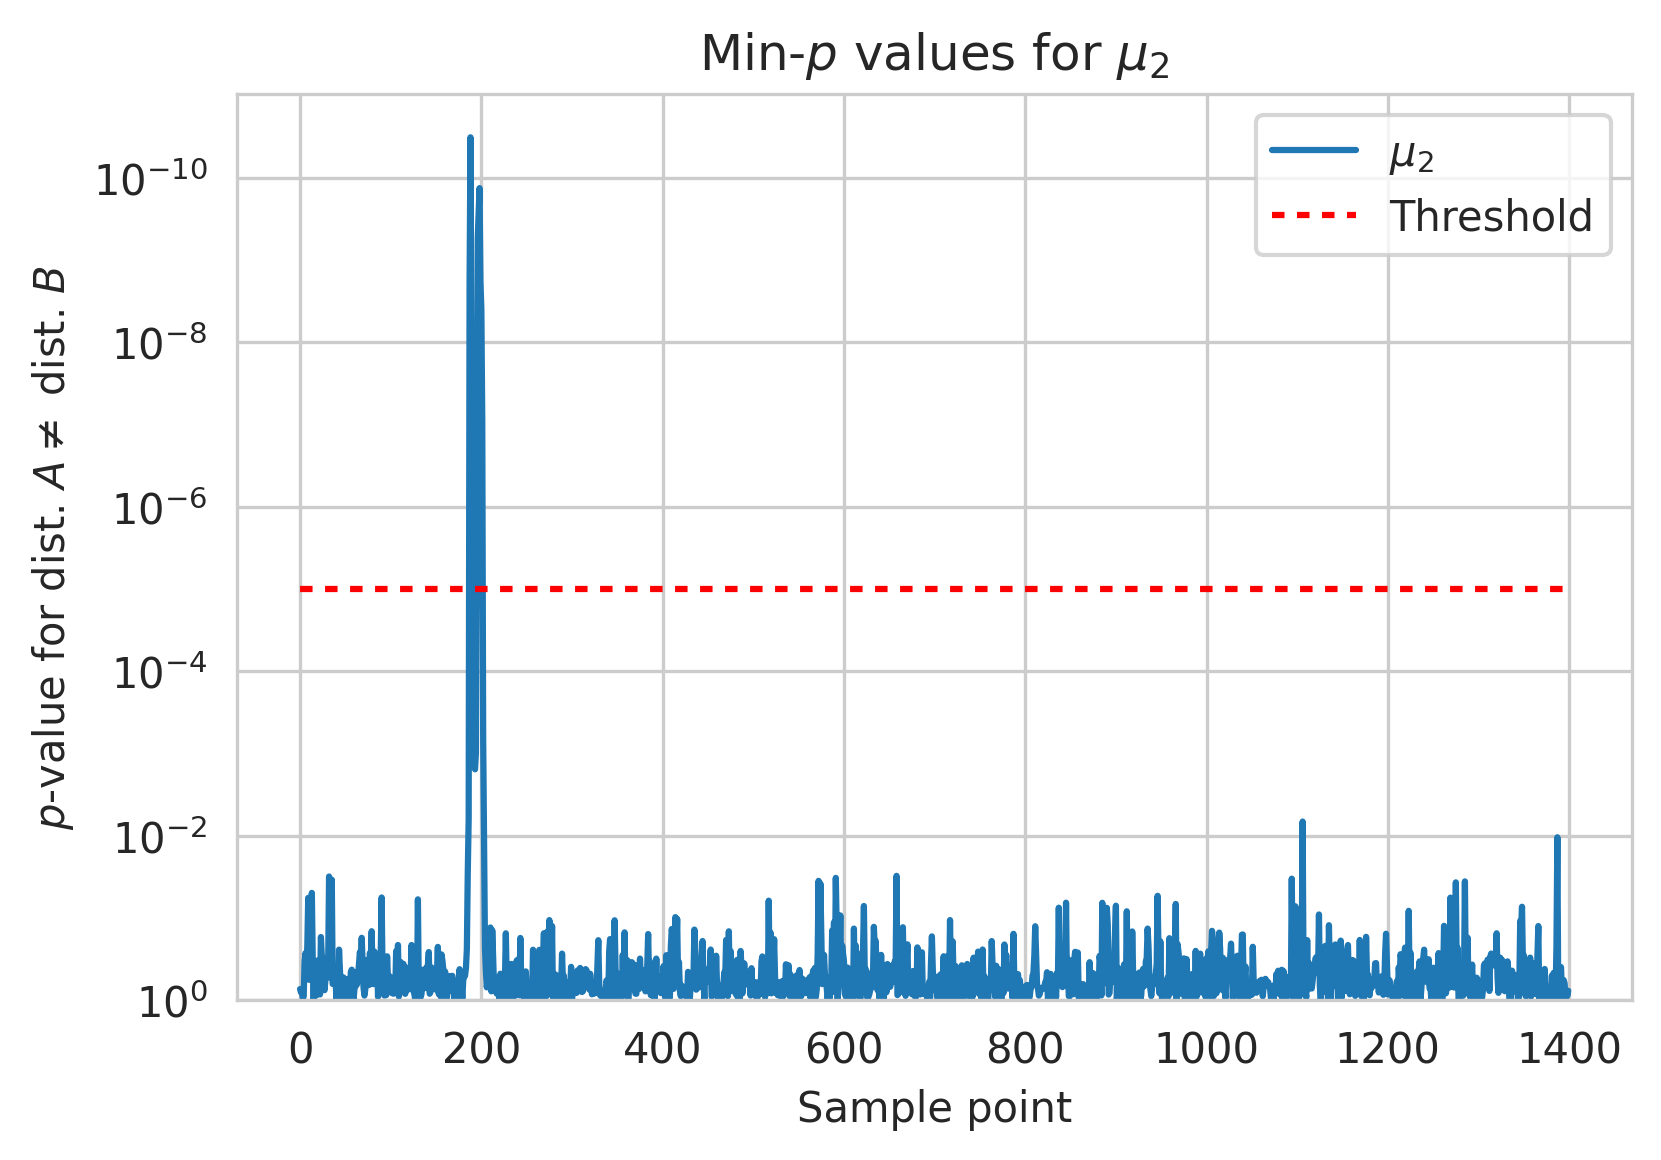

In [14]:
TVLA_AB.plot_min_p(2)

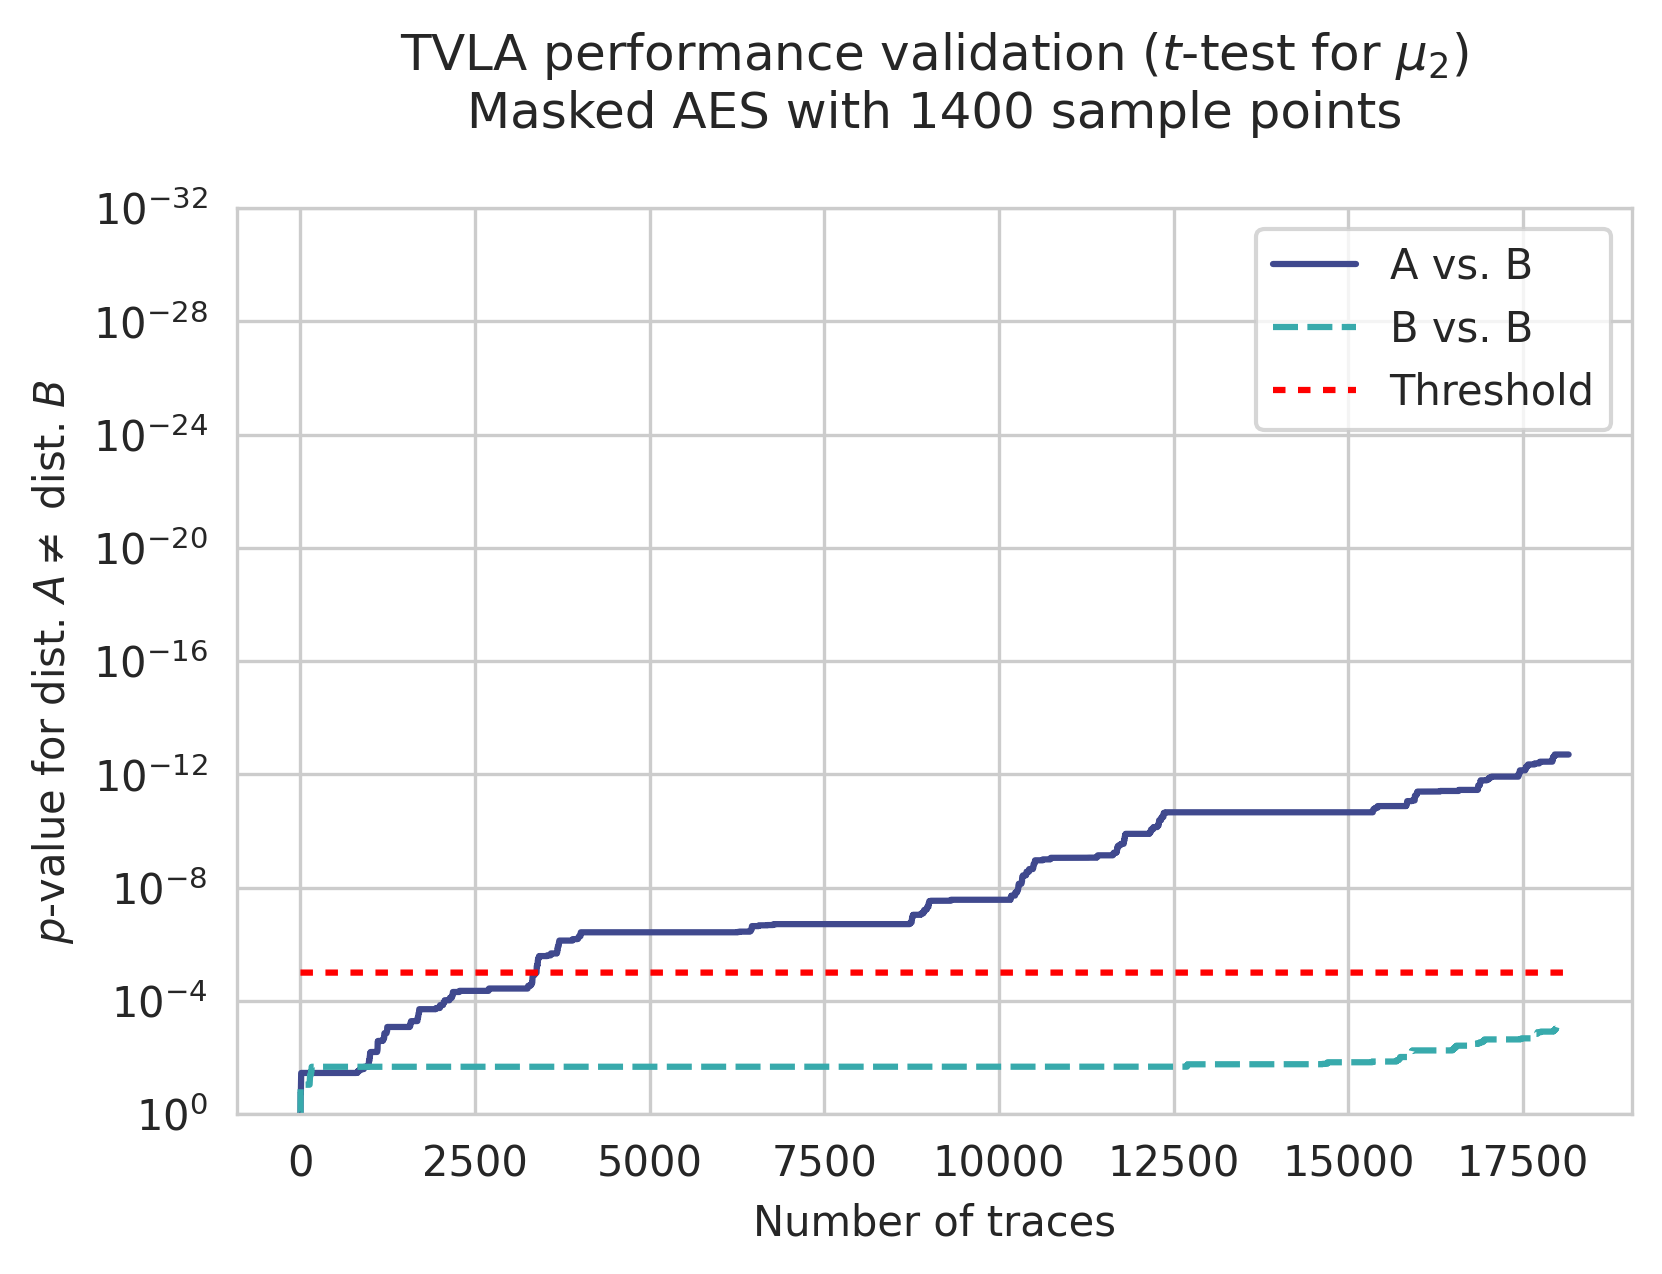

In [15]:
plot_p_gradient({
    "A vs. B": TVLA_AB.p_gradient(2),
    "B vs. B": TVLA_BB.p_gradient(2)
}, "TVLA performance validation ($t$-test for $\\mu_2$)\nMasked AES with 1400 sample points\n", palette=PALETTE_GRADIENT)

PG_LEN = len(TVLA_AB.p_gradient(2))

In [16]:
def randomize(y):
    """
    Shuffles a copy of the provided labels.
    """
    y = y.copy()
    np.random.shuffle(y)

    return y

In [17]:
PG_DLLA_9 = p_gradient_dl_la(best_model, x_att, y_att)["A vs. B"]
PG_DLLA_9_RANDOM = p_gradient_dl_la(best_model, x_att, randomize(y_att))["A vs. B"]

/usr/local/lib/python3.8/dist-packages/numpy-1.19.4-py3.8-linux-x86_64.egg/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy-1.19.4-py3.8-linux-x86_64.egg/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


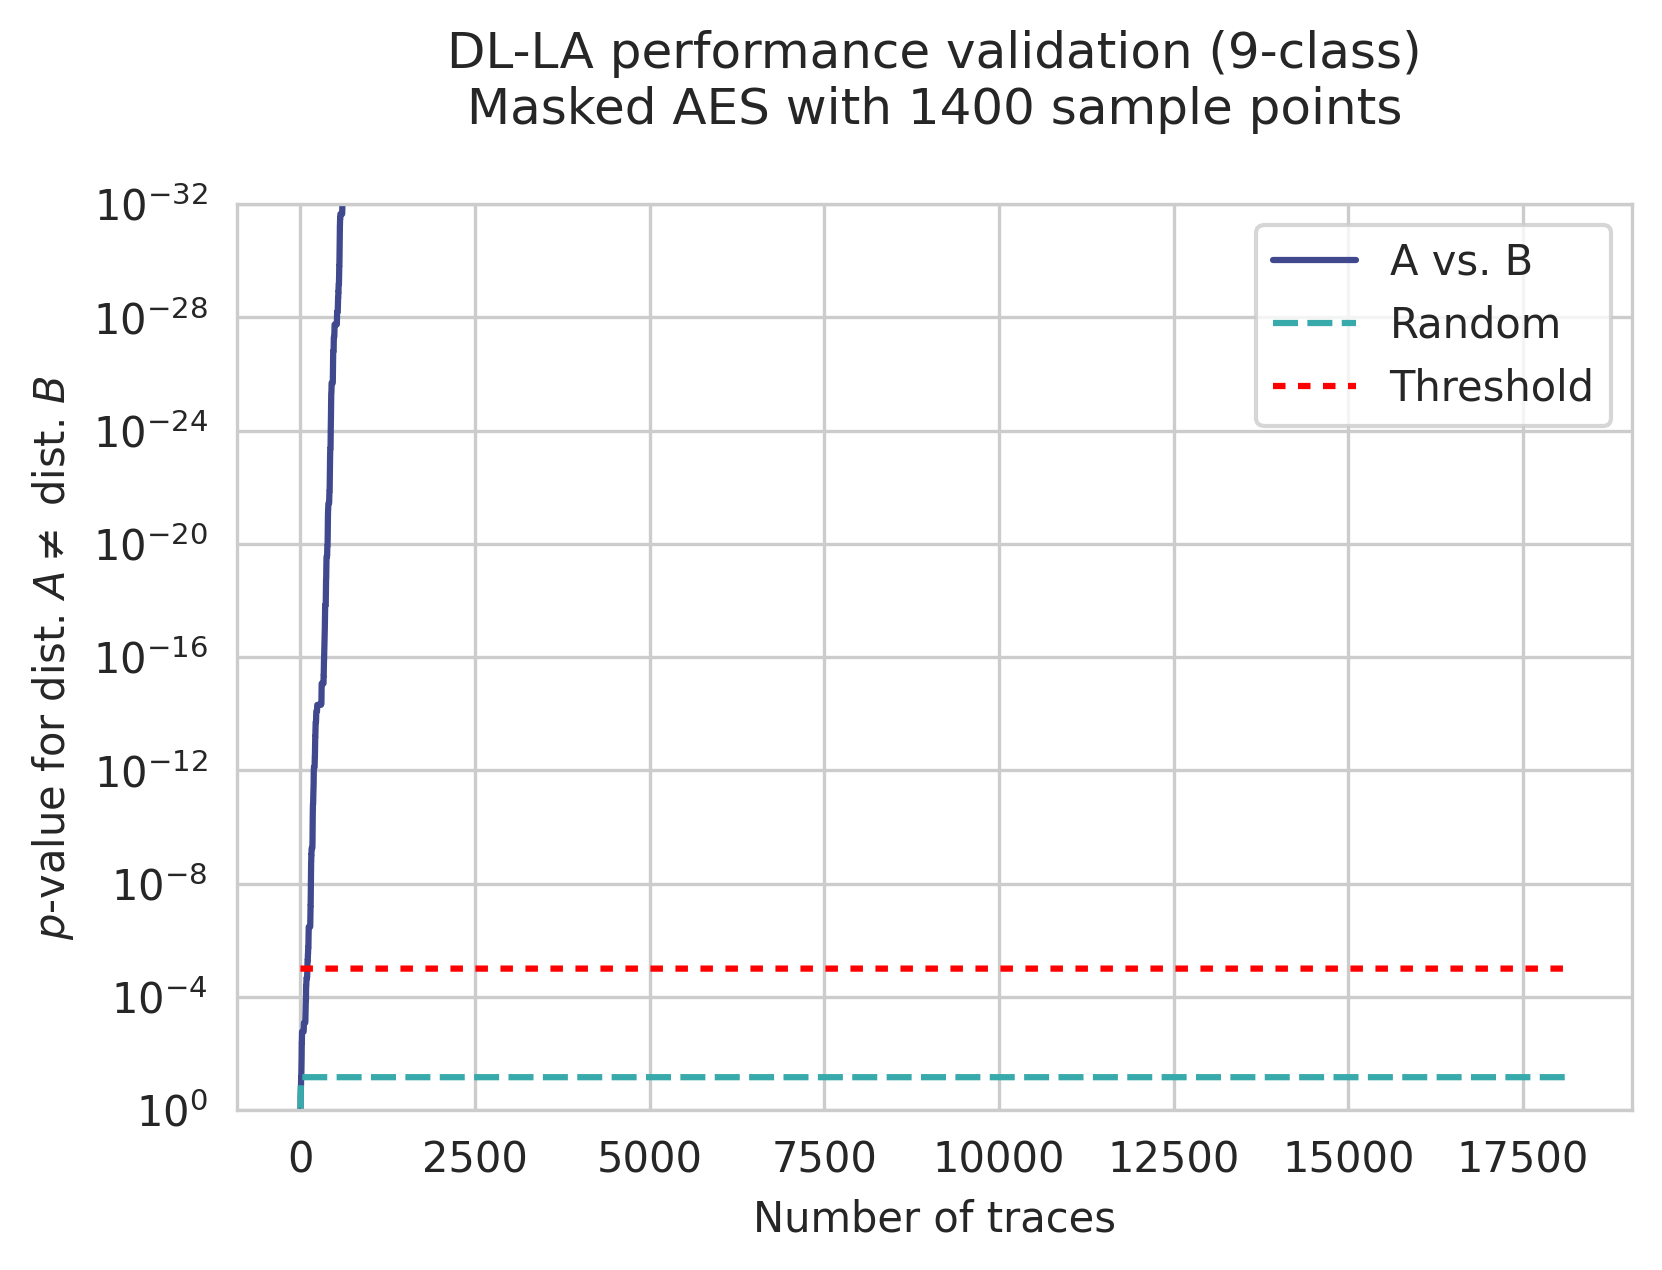

In [18]:
plot_p_gradient({
    "A vs. B": np.array(PG_DLLA_9),
    "Random": np.array(PG_DLLA_9_RANDOM),
}, "DL-LA performance validation (9-class)\nMasked AES with 1400 sample points\n", palette=PALETTE_GRADIENT)

In [19]:
def class_reduction(x, y):
    """
    Takes 9-class (categorical) hamming weight labels and reduces it to 2 classes.
    """
    numerical = y.argmax(axis=1)
    filter_ixs = numerical != 4

    numerical_reduced = numerical[filter_ixs] > 4

    return x[filter_ixs], to_categorical(numerical_reduced).astype(np.int8)

In [20]:
X_PROF_2, Y_PROF_2 = class_reduction(x_prof, y_prof)
X_ATT_2, Y_ATT_2 = class_reduction(x_att, y_att)
Y_ATT_2_RANDOM = randomize(Y_ATT_2)

In [21]:
MODEL_WEGENER_AB = make_mlp_wegener(X_PROF_2, Y_PROF_2, X_ATT_2, Y_ATT_2)

Epoch 1/5
970/970 [==============================] - 2s 2ms/step - loss: 0.2540 - accuracy: 0.5205 - val_loss: 0.2419 - val_accuracy: 0.5538

In [22]:
PG_DLLA_2_AB = dlla_p_gradient_wegener(MODEL_WEGENER_AB, X_ATT_2[:PG_LEN], Y_ATT_2[:PG_LEN])
PG_DLLA_2_RANDOM = dlla_p_gradient_wegener(MODEL_WEGENER_AB, X_ATT_2[:PG_LEN], Y_ATT_2_RANDOM[:PG_LEN])

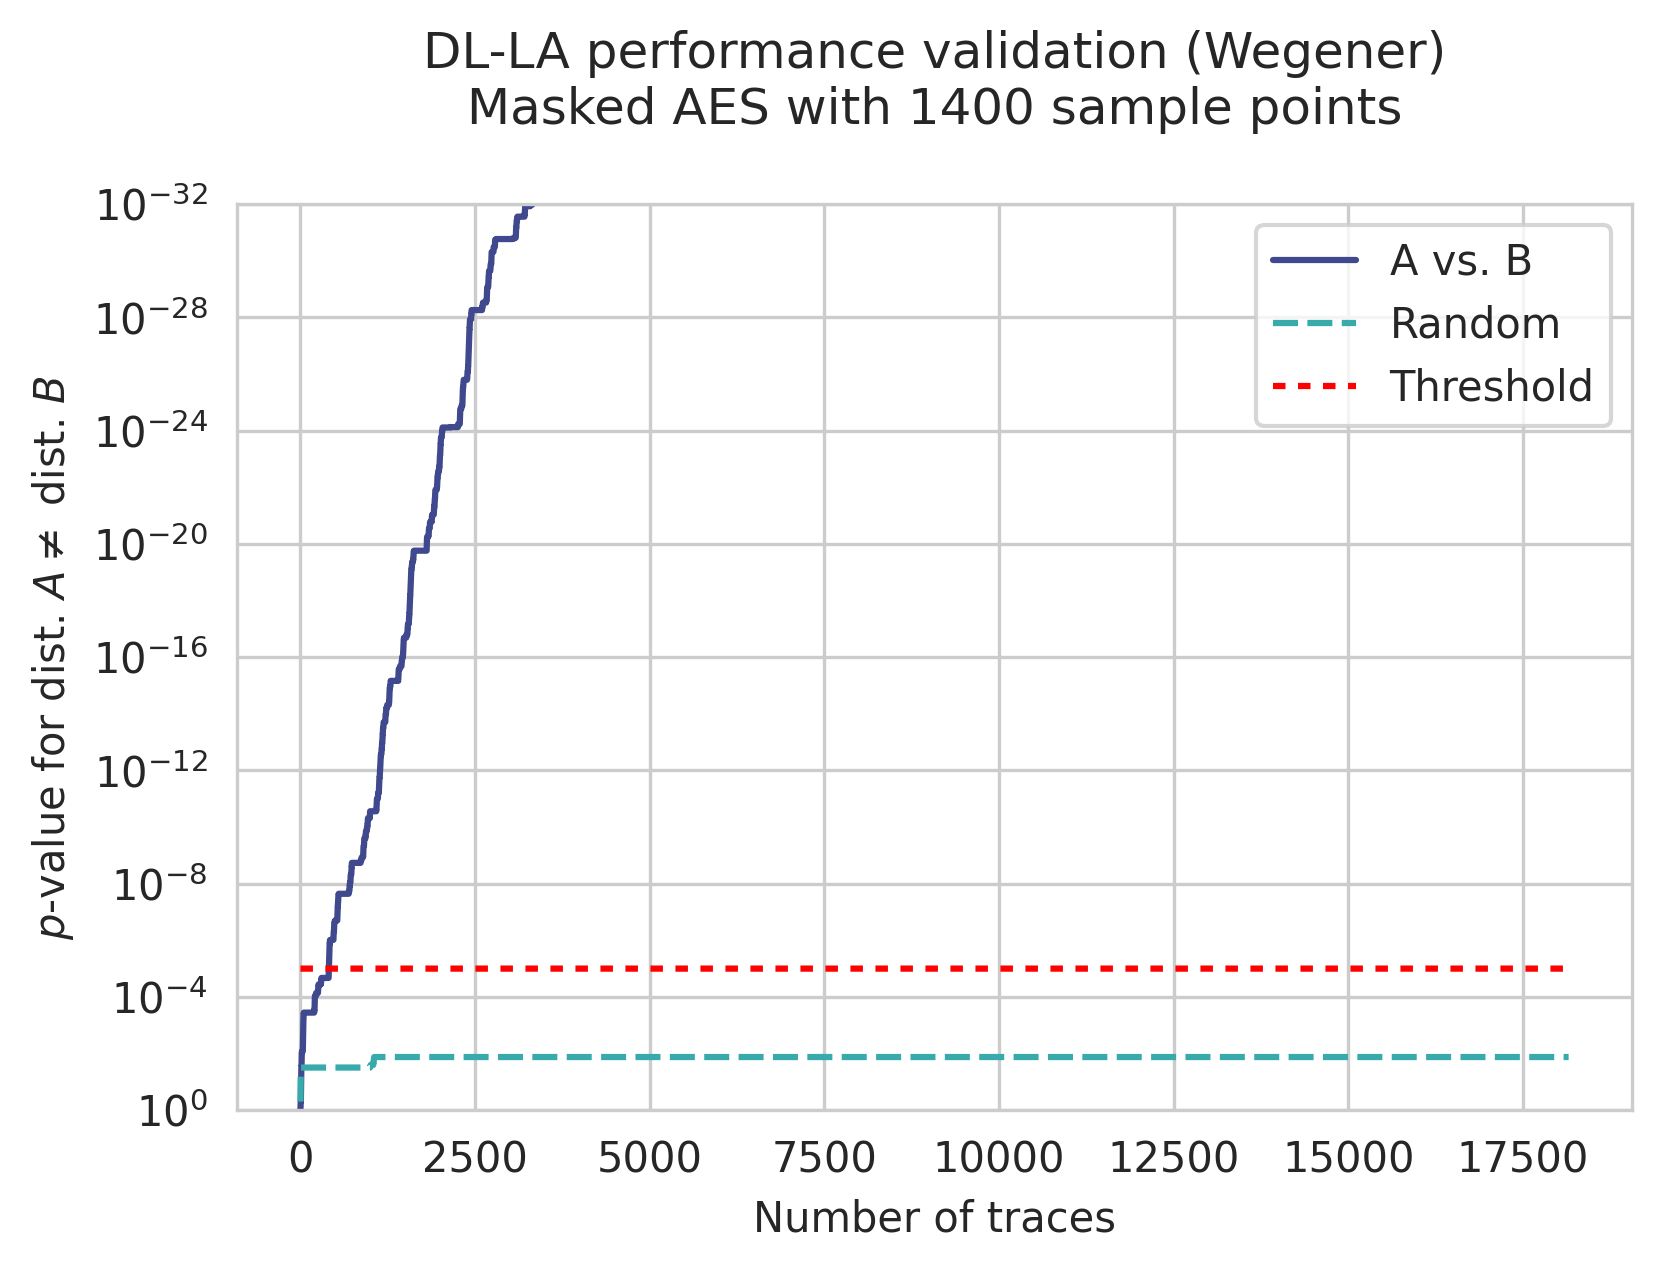

In [23]:
plot_p_gradient({
    "A vs. B": np.array(PG_DLLA_2_AB),
    "Random": np.array(PG_DLLA_2_RANDOM),
}, "DL-LA performance validation (Wegener)\nMasked AES with 1400 sample points\n", palette=PALETTE_GRADIENT)

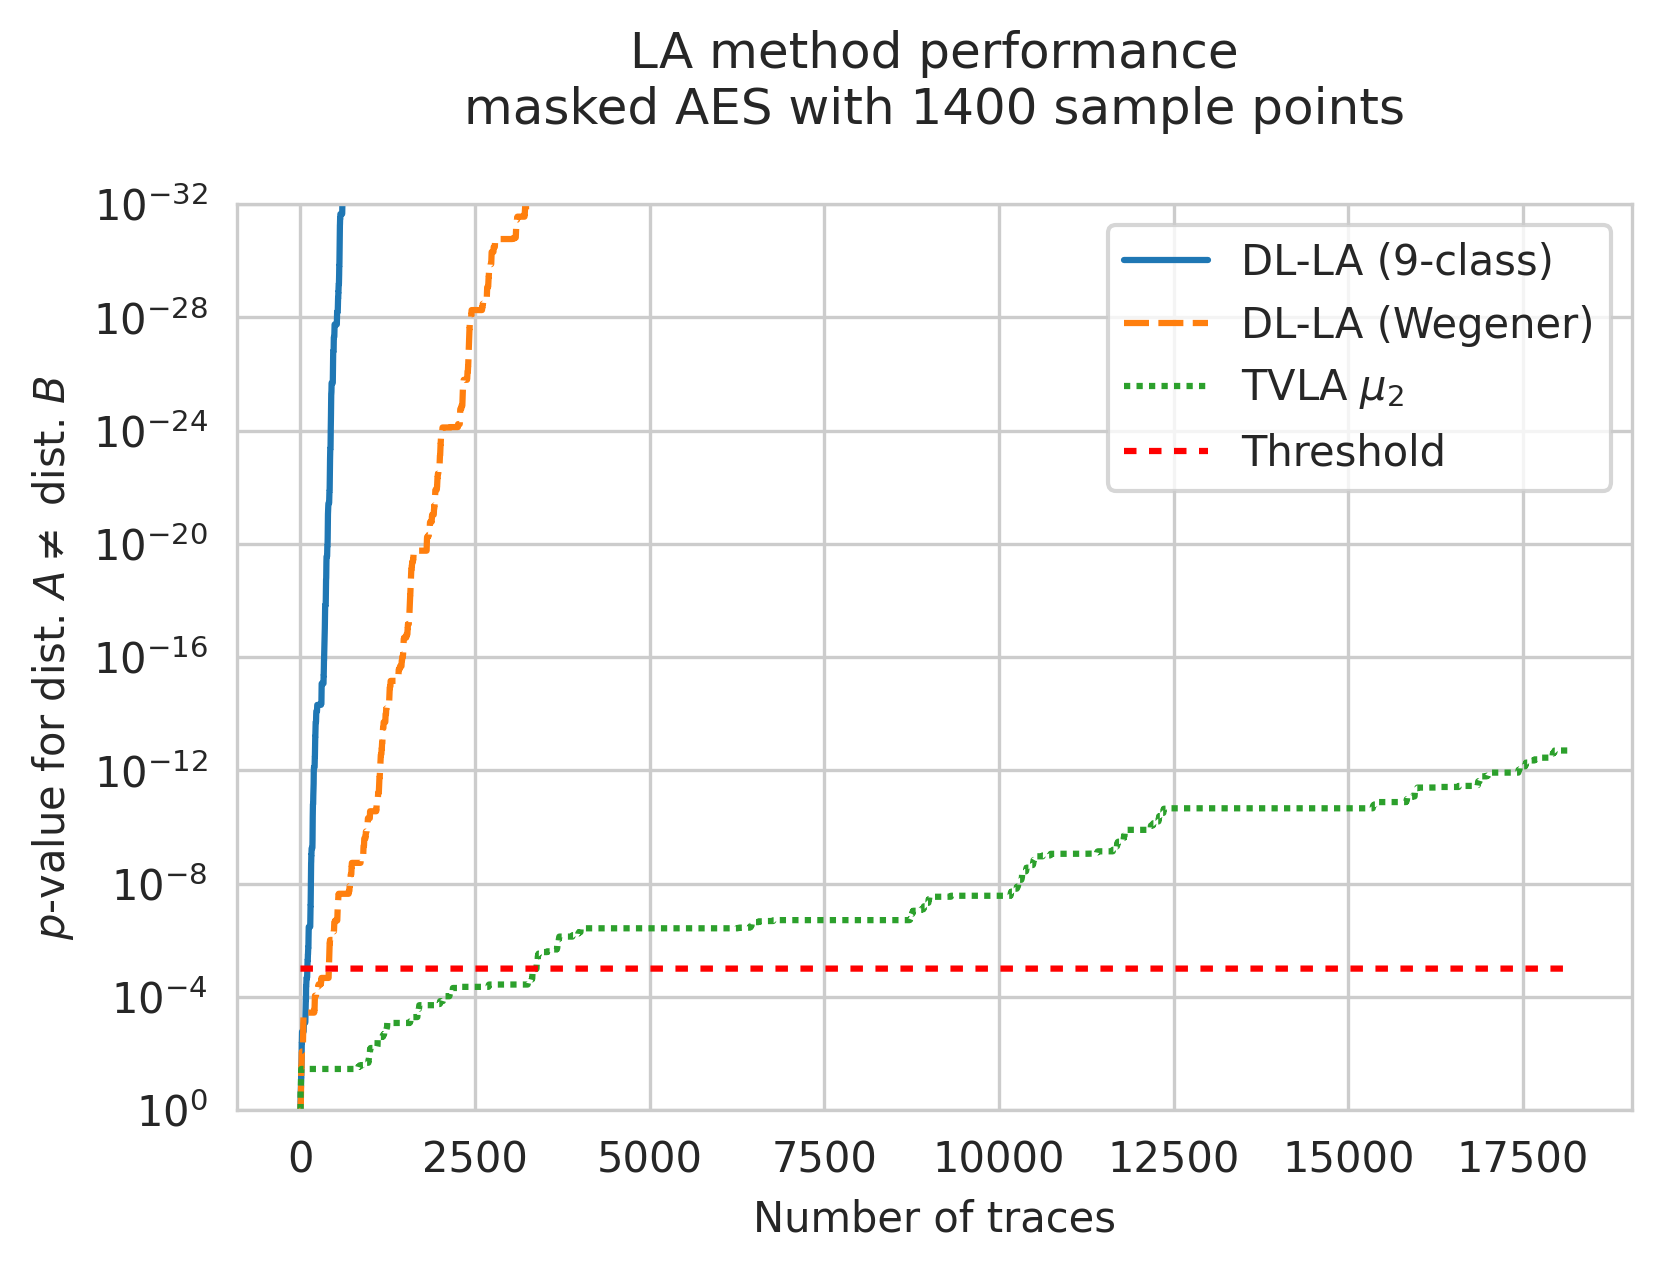

In [24]:
plot_p_gradient({
    "DL-LA (9-class)": np.array(PG_DLLA_9),
    "DL-LA (Wegener)": np.array(PG_DLLA_2_AB),
    "TVLA $\\mu_2$": TVLA_AB.p_gradient(2)
},"LA method performance\nmasked AES with 1400 sample points\n")